## Task II: Classical Graph Neural Network (GNN)

### For Task II, you will use ParticleNet’s data for Quark/Gluon jet classification available [here] with its corresponding description. 

[here]: https://zenodo.org/record/3164691#.ZAOA8nZBxPa

#### ● Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges. 
#### ● Discuss the resulting performance of the 2 chosen architectures. 


# SETUP 

### Importing libraries and setting up the GPU's for parallel and distributed training on kaggle GPU T4x2

In [2]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import tqdm.auto as tqdm
import matplotlib.pyplot as plt

In [4]:
#Single host,multi-device synchronus training

'''
The global batch of data is split into 
2 different sub-batches/local batches (as we have 2 GPU's)
The global batch has 64 samples in our case so 
local batch will have 32 samples and both the replicas 
independently process a local batch
'''

mirrored_strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))

Number of devices: 2


## Loading the Dataset

In [2]:
dataset=np.load('/kaggle/input/gsoc-2023/QG_jets.npz',allow_pickle=True)

In [3]:
list(dataset.keys())

['X', 'y']

In [4]:
X=dataset['X']
y=dataset['y']

## Data-PreProcessing
### According to the information present [here]
[here]:https://zenodo.org/record/3164691#.ZAOA8nZBxPa
### About Data Each numpy file constitutes of data in the following format-

### There are two arrays in each file -

#### X: (100000,M,4), exactly 50k quark and 50k gluon jets, randomly sorted, where M is the max multiplicity of the jets in that file (other jets have been padded with zero-particles), and the features of each particle are its pt, rapidity, azimuthal angle, and pdgid.
#### y: (100000,), an array of labels for the jets where gluon is 0 and quark is 1.

In [5]:
#Used for one-hot encoding the labels to prevent value errors
y=tf.keras.utils.to_categorical(y)
 

In [6]:
#Splitting the data into train,test,validation.
X_train_1,X_test,y_train_1,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
X_train,X_val,y_train,y_val=train_test_split(X_train_1,y_train_1,test_size=0.15,random_state=42)

print(X_train.shape)
print(y_train.shape)
print('_____________')
print(X_test.shape)
print(y_test.shape)
print('_____________')
print(X_val.shape)
print(y_val.shape)

(63750, 139, 4)
(63750, 2)
_____________
(25000, 139, 4)
(25000, 2)
_____________
(11250, 139, 4)
(11250, 2)


In [7]:
#Creating training masks
train_mask=np.sum(X_train,axis=2)
train_mask=np.array(train_mask!=0,np.float32)
train_mask=train_mask.reshape(X_train.shape[0],X_train.shape[1],1)

In [8]:
#Creating testing masks
test_mask=np.sum(X_test,axis=2)
test_mask=np.array(test_mask!=0,np.float32)
test_mask=test_mask.reshape(X_test.shape[0],X_test.shape[1],1)

In [9]:
#Creating validation masks
val_mask=np.sum(X_val,axis=2)
val_mask=np.array(val_mask!=0,np.float32)
val_mask=val_mask.reshape(X_val.shape[0],X_val.shape[1],1)

## According to the paper [Jet Tagging via Particle Clouds]
[Jet Tagging Via Particle Clouds]:https://arxiv.org/pdf/1902.08570.pdf

#### The success of convolution accounts to two main factors first being the convolution operation exploits translational symmetry of images by using shared kernels across the whole image and the second being CNNs exploit a hierarchical approach for learning image features. The convolution operations can be effectively stacked to form a deep network. Different layers in the CNNs have different receptive fields and therefore can learn features at different scales, with the shallower layers exploiting local neighborhood information and the deeper layers learning more global structures.

#### But regular convolution operation cannot be applied on point clouds, as the points there can be distributed irregularly, rather than following some uniform grids as the pixels in an image.

#### Hence this paper utilizes the method of **EdgeConv**,a convolution like operation for point clouds. EdgeConv operation can be easily stacked like normal convolution making it highly suitable for point clouds. The proximity of points can be dynamically learned with EdgeConv operations.

#### ParticleNet utilized EdgeConv extensively. It consists of three EdgeConv blocks.The first EdgeConv block uses the spatial coordinates of particles in the pseudorapidity-azimuth space to compute the distances, while the subsequent blocks use the learned feature vectors as coordinates.The number of nearest neighbors k is 16 for all three blocks, and the number of channels C for each EdgeConv block is (64, 64,64), (128, 128, 128), and (256, 256, 256), respectively making it computationally intensive model.

#### ParticleNet-Lite is a variation of the ParticleNet model that utilizes a more lightweight approach. It consists of two EdgeConv blocks, where the number of nearest neighbors has been reduced to 7 for both blocks. The number of channels for the two blocks is also reduced, specifically (32, 32, 32) and (64, 64, 64), respectively. Additionally, the number of units in the fully connected layer after pooling has been decreased from 256 in the original ParticleNet architecture to 128 in ParticleNet-Lite. These modifications result in a significant reduction in the number of arithmetic operations, making ParticleNet-Lite more efficient and suitable for use in scenarios where computational resources are limited.


In [10]:
train_data={'points':X_train[:,:,1:3],
            'features': X_train,
             'mask':train_mask}

In [11]:
test_data={'points':X_test[:,:,1:3],
            'features': X_test,
             'mask':test_mask}

In [12]:
val_data={'points':X_val[:,:,1:3],
            'features': X_val,
             'mask':val_mask}


#### **points** contain the rapidity,azimuthal angle which are used for computing the distances in KNN as stated in the paper [Jet Tagging Via Particle Clouds]

[Jet Tagging Via Particle Clouds]:https://arxiv.org/pdf/1902.08570.pdf

#### **features** contains all the four features pt, rapidity, azimuthal angle, and pdgid.

#### **mask** is an array that has the value 0 for the padded positions

### The implementation of the code below has been taken from the following [github repository]

[github repository]: https://github.com/hqucms/ParticleNet

In [13]:
import tensorflow as tf
from tensorflow import keras


# A shape is (N, P_A, C), B shape is (N, P_B, C)
# D shape is (N, P_A, P_B)
def batch_distance_matrix_general(A, B):
    with tf.name_scope('dmat'):
        r_A = tf.reduce_sum(A * A, axis=2, keepdims=True)
        r_B = tf.reduce_sum(B * B, axis=2, keepdims=True)
        m = tf.matmul(A, tf.transpose(B, perm=(0, 2, 1)))
        D = r_A - 2 * m + tf.transpose(r_B, perm=(0, 2, 1))
        return D


def knn(num_points, k, topk_indices, features):
    # topk_indices: (N, P, K)
    # features: (N, P, C)
    with tf.name_scope('knn'):
        queries_shape = tf.shape(features)
        batch_size = queries_shape[0]
        batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, num_points, k, 1))
        indices = tf.concat([batch_indices, tf.expand_dims(topk_indices, axis=3)], axis=3)  # (N, P, K, 2)
        return tf.gather_nd(features, indices)


def edge_conv(points, features, num_points, K, channels, with_bn=True, activation='relu', pooling='average', name='edgeconv'):
    """EdgeConv
    Args:
        K: int, number of neighbors
        in_channels: # of input channels
        channels: tuple of output channels
        pooling: pooling method ('max' or 'average')
    Inputs:
        points: (N, P, C_p)
        features: (N, P, C_0)
    Returns:
        transformed points: (N, P, C_out), C_out = channels[-1]
    """

    with tf.name_scope('edgeconv'):

        # distance
        D = batch_distance_matrix_general(points, points)  # (N, P, P)
        _, indices = tf.nn.top_k(-D, k=K + 1)  # (N, P, K+1)
        indices = indices[:, :, 1:]  # (N, P, K)

        fts = features
        knn_fts = knn(num_points, K, indices, fts)  # (N, P, K, C)
        knn_fts_center = tf.tile(tf.expand_dims(fts, axis=2), (1, 1, K, 1))  # (N, P, K, C)
        knn_fts = tf.concat([knn_fts_center, tf.subtract(knn_fts, knn_fts_center)], axis=-1)  # (N, P, K, 2*C)

        x = knn_fts
        for idx, channel in enumerate(channels):
            x = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=1, data_format='channels_last',
                                    use_bias=False if with_bn else True, kernel_initializer='glorot_normal', name='%s_conv%d' % (name, idx))(x)
            if with_bn:
                x = keras.layers.BatchNormalization(name='%s_bn%d' % (name, idx))(x)
            if activation:
                x = keras.layers.Activation(activation, name='%s_act%d' % (name, idx))(x)

        if pooling == 'max':
            fts = tf.reduce_max(x, axis=2)  # (N, P, C')
        else:
            fts = tf.reduce_mean(x, axis=2)  # (N, P, C')

        # shortcut
        sc = keras.layers.Conv2D(channels[-1], kernel_size=(1, 1), strides=1, data_format='channels_last',
                                 use_bias=False if with_bn else True, kernel_initializer='glorot_normal', name='%s_sc_conv' % name)(tf.expand_dims(features, axis=2))
        if with_bn:
            sc = keras.layers.BatchNormalization(name='%s_sc_bn' % name)(sc)
        sc = tf.squeeze(sc, axis=2)

        if activation:
            return keras.layers.Activation(activation, name='%s_sc_act' % name)(sc + fts)  # (N, P, C')
        else:
            return sc + fts


def _particle_net_base(points, features=None, mask=None, setting=None, name='particle_net'):
    # points : (N, P, C_coord)
    # features:  (N, P, C_features), optional
    # mask: (N, P, 1), optinal

    with tf.name_scope(name):
        if features is None:
            features = points

        if mask is not None:
            mask = tf.cast(tf.not_equal(mask, 0), dtype='float32')  # 1 if valid
            coord_shift = tf.multiply(999., tf.cast(tf.equal(mask, 0), dtype='float32'))  # make non-valid positions to 99

        fts = tf.squeeze(keras.layers.BatchNormalization(name='%s_fts_bn' % name)(tf.expand_dims(features, axis=2)), axis=2)
        for layer_idx, layer_param in enumerate(setting.conv_params):
            K, channels = layer_param
            pts = tf.add(coord_shift, points) if layer_idx == 0 else tf.add(coord_shift, fts)
            fts = edge_conv(pts, fts, setting.num_points, K, channels, with_bn=True, activation='relu',
                            pooling=setting.conv_pooling, name='%s_%s%d' % (name, 'EdgeConv', layer_idx))

        if mask is not None:
            fts = tf.multiply(fts, mask)

        pool = tf.reduce_mean(fts, axis=1)  # (N, C)

        if setting.fc_params is not None:
            x = pool
            for layer_idx, layer_param in enumerate(setting.fc_params):
                units, drop_rate = layer_param
                x = keras.layers.Dense(units, activation='relu')(x)
                if drop_rate is not None and drop_rate > 0:
                    x = keras.layers.Dropout(drop_rate)(x)
            out = keras.layers.Dense(setting.num_class, activation='softmax')(x)
            return out  # (N, num_classes)
        else:
            return pool


class _DotDict:
    pass


def get_particle_net(num_classes, input_shapes):
    r"""ParticleNet model from `"ParticleNet: Jet Tagging via Particle Clouds"
    <https://arxiv.org/abs/1902.08570>`_ paper.
    Parameters
    ----------
    num_classes : int
        Number of output classes.
    input_shapes : dict
        The shapes of each input (`points`, `features`, `mask`).
    """
    setting = _DotDict()
    setting.num_class = num_classes
    # conv_params: list of tuple in the format (K, (C1, C2, C3))
    setting.conv_params = [
        (16, (64, 64, 64)),
        (16, (128, 128, 128)),
        (16, (256, 256, 256)),
        ]
    # conv_pooling: 'average' or 'max'
    setting.conv_pooling = 'average'
    # fc_params: list of tuples in the format (C, drop_rate)
    setting.fc_params = [(256, 0.1)]
    setting.num_points = input_shapes['points'][0]

    points = keras.Input(name='points', shape=input_shapes['points'])
    features = keras.Input(name='features', shape=input_shapes['features']) if 'features' in input_shapes else None
    mask = keras.Input(name='mask', shape=input_shapes['mask']) if 'mask' in input_shapes else None
    outputs = _particle_net_base(points, features, mask, setting, name='ParticleNet')

    return keras.Model(inputs=[points, features, mask], outputs=outputs, name='ParticleNet')


def get_particle_net_lite(num_classes, input_shapes):
    r"""ParticleNet-Lite model from `"ParticleNet: Jet Tagging via Particle Clouds"
    <https://arxiv.org/abs/1902.08570>`_ paper.
    Parameters
    ----------
    num_classes : int
        Number of output classes.
    input_shapes : dict
        The shapes of each input (`points`, `features`, `mask`).
    """
    setting = _DotDict()
    setting.num_class = num_classes
    # conv_params: list of tuple in the format (K, (C1, C2, C3))
    setting.conv_params = [
        (7, (32, 32, 32)),
        (7, (64, 64, 64)),
        ]
    # conv_pooling: 'average' or 'max'
    setting.conv_pooling = 'average'
    # fc_params: list of tuples in the format (C, drop_rate)
    setting.fc_params = [(128, 0.1)]
    setting.num_points = input_shapes['points'][0]

    points = keras.Input(name='points', shape=input_shapes['points'])
    features = keras.Input(name='features', shape=input_shapes['features']) if 'features' in input_shapes else None
    mask = keras.Input(name='mask', shape=input_shapes['mask']) if 'mask' in input_shapes else None
    outputs = _particle_net_base(points, features, mask, setting, name='ParticleNet')

    return keras.Model(inputs=[points, features, mask], outputs=outputs, name='ParticleNet')

In [14]:
input_shapes={'points':X_train[:,:,1:3].shape[1:],'features':X_train.shape[1:],'mask': train_mask.shape[1:]}


In [15]:
batch_size=64
steps_per_epoch = 63750 // batch_size
validation_steps = 11250 // batch_size

# TRAINING

In [32]:
'''
Using the strategy instantiated before to open a scope and 
 create and compile the model inside the distribution scope 
for parallel and distributed computing.
'''
with mirrored_strategy.scope(): 
    model=get_particle_net(2,input_shapes)
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                  steps_per_execution=50,
                  metrics=['accuracy','AUC'])

In [33]:

results=model.fit(train_data,y_train,batch_size=batch_size,epochs=50,
                  steps_per_epoch=steps_per_epoch,validation_data=(val_data,y_val),
                  validation_steps=validation_steps,shuffle=True)

Epoch 1/50
996/996 [==============================] - 150s 151ms/step - loss: 0.4825 - accuracy: 0.7775 - auc: 0.8506 - val_loss: 0.4622 - val_accuracy: 0.7892 - val_auc: 0.8643
Epoch 2/50
996/996 [==============================] - 123s 123ms/step - loss: 0.4574 - accuracy: 0.7941 - auc: 0.8670 - val_loss: 0.4486 - val_accuracy: 0.7954 - val_auc: 0.8727
Epoch 3/50
996/996 [==============================] - 123s 124ms/step - loss: 0.4477 - accuracy: 0.7999 - auc: 0.8729 - val_loss: 0.4433 - val_accuracy: 0.8001 - val_auc: 0.8771
Epoch 4/50
996/996 [==============================] - 122s 123ms/step - loss: 0.4445 - accuracy: 0.8000 - auc: 0.8749 - val_loss: 0.4365 - val_accuracy: 0.8054 - val_auc: 0.8801
Epoch 5/50
996/996 [==============================] - 124s 124ms/step - loss: 0.4398 - accuracy: 0.8025 - auc: 0.8778 - val_loss: 0.4497 - val_accuracy: 0.7974 - val_auc: 0.8728
Epoch 6/50
996/996 [==============================] - 122s 123ms/step - loss: 0.4370 - accuracy: 0.8041 - auc:

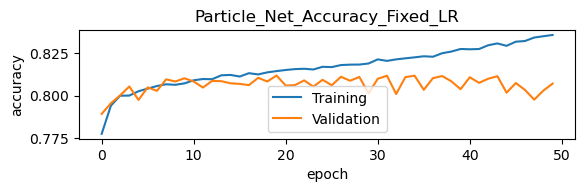

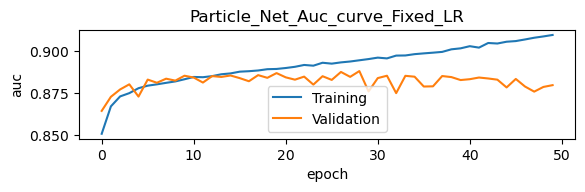

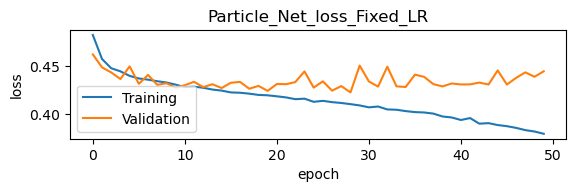

In [34]:

plt.subplot(3,1,1)
plt.plot(results.history['accuracy'],label='Training')
plt.plot(results.history['val_accuracy'],label='Validation')
plt.title('Particle_Net_Accuracy_Fixed_LR')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.subplot(3,1,2)
plt.plot(results.history['auc'],label='Training')
plt.plot(results.history['val_auc'],label='Validation')
plt.title('Particle_Net_Auc_curve_Fixed_LR')
plt.xlabel('epoch')
plt.ylabel('auc')
plt.legend()
plt.show()

plt.subplot(3,1,3)
plt.plot(results.history['loss'],label='Training')
plt.plot(results.history['val_loss'],label='Validation')
plt.title('Particle_Net_loss_Fixed_LR')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [17]:
with mirrored_strategy.scope():
    model_lite=get_particle_net_lite(2,input_shapes)
    model_lite.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                  steps_per_execution=50,
                  metrics=['accuracy','AUC'])

In [18]:

results_lite=model_lite.fit(train_data,y_train,batch_size=batch_size,epochs=50,
                  steps_per_epoch=steps_per_epoch,validation_data=(val_data,y_val),
                  validation_steps=validation_steps,shuffle=True)

Epoch 1/50
996/996 [==============================] - 76s 76ms/step - loss: 0.5037 - accuracy: 0.7632 - auc: 0.8354 - val_loss: 0.4831 - val_accuracy: 0.7746 - val_auc: 0.8495
Epoch 2/50
996/996 [==============================] - 41s 41ms/step - loss: 0.4823 - accuracy: 0.7768 - auc: 0.8505 - val_loss: 0.4760 - val_accuracy: 0.7784 - val_auc: 0.8543
Epoch 3/50
996/996 [==============================] - 41s 41ms/step - loss: 0.4731 - accuracy: 0.7836 - auc: 0.8565 - val_loss: 0.4650 - val_accuracy: 0.7846 - val_auc: 0.8626
Epoch 4/50
996/996 [==============================] - 40s 41ms/step - loss: 0.4624 - accuracy: 0.7909 - auc: 0.8637 - val_loss: 0.4599 - val_accuracy: 0.7907 - val_auc: 0.8654
Epoch 5/50
996/996 [==============================] - 41s 41ms/step - loss: 0.4559 - accuracy: 0.7960 - auc: 0.8677 - val_loss: 0.4551 - val_accuracy: 0.7895 - val_auc: 0.8683
Epoch 6/50
996/996 [==============================] - 42s 42ms/step - loss: 0.4525 - accuracy: 0.7972 - auc: 0.8698 - va

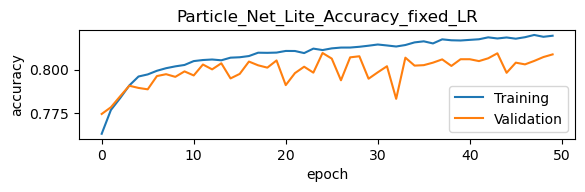

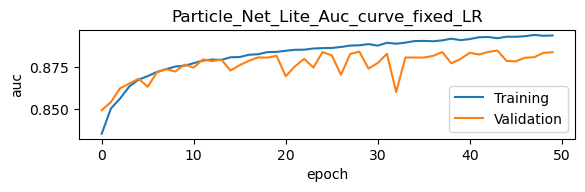

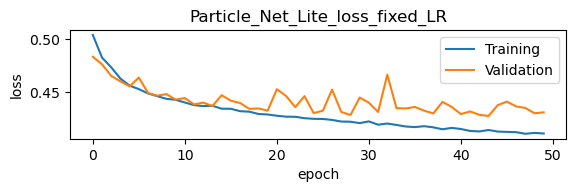

In [21]:

plt.subplot(3,1,1)
plt.plot(results_lite.history['accuracy'],label='Training')
plt.plot(results_lite.history['val_accuracy'],label='Validation')
plt.title('Particle_Net_Lite_Accuracy_fixed_LR')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.subplot(3,1,2)
plt.plot(results_lite.history['auc'],label='Training')
plt.plot(results_lite.history['val_auc'],label='Validation')
plt.title('Particle_Net_Lite_Auc_curve_fixed_LR')
plt.xlabel('epoch')
plt.ylabel('auc')
plt.legend()
plt.show()

plt.subplot(3,1,3)
plt.plot(results_lite.history['loss'],label='Training')
plt.plot(results_lite.history['val_loss'],label='Validation')
plt.title('Particle_Net_Lite_loss_fixed_LR')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [22]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    return lr

In [24]:
with mirrored_strategy.scope():
    model_lr_schedule_lite=get_particle_net_lite(2,input_shapes)
    model_lr_schedule_lite.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule(0)),
                  steps_per_execution=50,
                  metrics=['accuracy','AUC'])

In [25]:
results_lr_schedule_lite=model_lr_schedule_lite.fit(train_data,y_train,batch_size=batch_size,epochs=50,
                  steps_per_epoch=steps_per_epoch,validation_data=(val_data,y_val),
                  validation_steps=validation_steps,shuffle=True)

Epoch 1/50
996/996 [==============================] - 66s 66ms/step - loss: 0.4928 - accuracy: 0.7693 - auc: 0.8429 - val_loss: 0.4986 - val_accuracy: 0.7661 - val_auc: 0.8387
Epoch 2/50
996/996 [==============================] - 40s 40ms/step - loss: 0.4703 - accuracy: 0.7852 - auc: 0.8584 - val_loss: 0.4600 - val_accuracy: 0.7882 - val_auc: 0.8650
Epoch 3/50
996/996 [==============================] - 40s 40ms/step - loss: 0.4562 - accuracy: 0.7954 - auc: 0.8675 - val_loss: 0.4611 - val_accuracy: 0.7886 - val_auc: 0.8650
Epoch 4/50
996/996 [==============================] - 41s 41ms/step - loss: 0.4494 - accuracy: 0.7983 - auc: 0.8719 - val_loss: 0.4491 - val_accuracy: 0.7976 - val_auc: 0.8734
Epoch 5/50
996/996 [==============================] - 41s 42ms/step - loss: 0.4451 - accuracy: 0.8006 - auc: 0.8746 - val_loss: 0.4552 - val_accuracy: 0.7901 - val_auc: 0.8691
Epoch 6/50
996/996 [==============================] - 41s 41ms/step - loss: 0.4412 - accuracy: 0.8034 - auc: 0.8771 - va

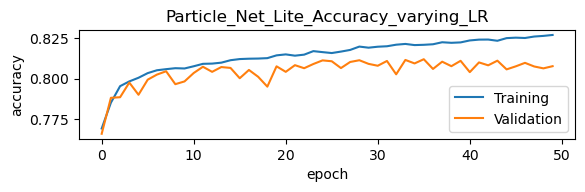

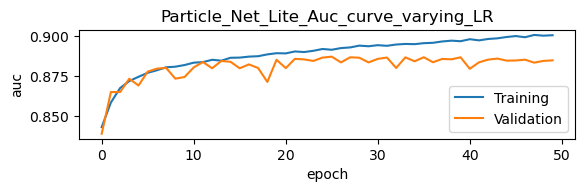

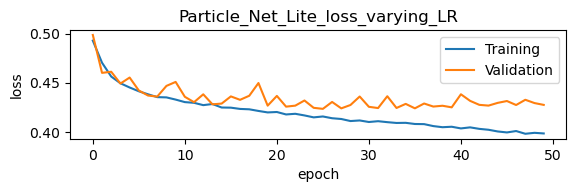

In [27]:
plt.subplot(3,1,1)
plt.plot(results_lr_schedule_lite.history['accuracy'],label='Training')
plt.plot(results_lr_schedule_lite.history['val_accuracy'],label='Validation')
plt.title('Particle_Net_Lite_Accuracy_varying_LR')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.subplot(3,1,2)
plt.plot(results_lr_schedule_lite.history['auc'],label='Training')
plt.plot(results_lr_schedule_lite.history['val_auc'],label='Validation')
plt.title('Particle_Net_Lite_Auc_curve_varying_LR')
plt.xlabel('epoch')
plt.ylabel('auc')
plt.legend()
plt.show()

plt.subplot(3,1,3)
plt.plot(results_lr_schedule_lite.history['loss'],label='Training')
plt.plot(results_lr_schedule_lite.history['val_loss'],label='Validation')
plt.title('Particle_Net_Lite_loss_varying_LR')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [28]:
with mirrored_strategy.scope():
    model_lr_schedule=get_particle_net(2,input_shapes)
    model_lr_schedule.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule(0)),
                  steps_per_execution=50,
                  metrics=['accuracy','AUC'])

In [29]:
results_lr_schedule=model_lr_schedule.fit(train_data,y_train,batch_size=batch_size,epochs=50,
                  steps_per_epoch=steps_per_epoch,validation_data=(val_data,y_val),
                  validation_steps=validation_steps,shuffle=True)

Epoch 1/50
996/996 [==============================] - 156s 157ms/step - loss: 0.4788 - accuracy: 0.7813 - auc: 0.8532 - val_loss: 0.5190 - val_accuracy: 0.7659 - val_auc: 0.8349
Epoch 2/50
996/996 [==============================] - 123s 124ms/step - loss: 0.4531 - accuracy: 0.7974 - auc: 0.8698 - val_loss: 0.4478 - val_accuracy: 0.7990 - val_auc: 0.8736
Epoch 3/50
996/996 [==============================] - 122s 123ms/step - loss: 0.4474 - accuracy: 0.8006 - auc: 0.8731 - val_loss: 0.4395 - val_accuracy: 0.8043 - val_auc: 0.8779
Epoch 4/50
996/996 [==============================] - 122s 123ms/step - loss: 0.4423 - accuracy: 0.8037 - auc: 0.8763 - val_loss: 0.4836 - val_accuracy: 0.7654 - val_auc: 0.8481
Epoch 5/50
996/996 [==============================] - 123s 124ms/step - loss: 0.4397 - accuracy: 0.8041 - auc: 0.8779 - val_loss: 0.4402 - val_accuracy: 0.8002 - val_auc: 0.8778
Epoch 6/50
996/996 [==============================] - 123s 124ms/step - loss: 0.4376 - accuracy: 0.8050 - auc:

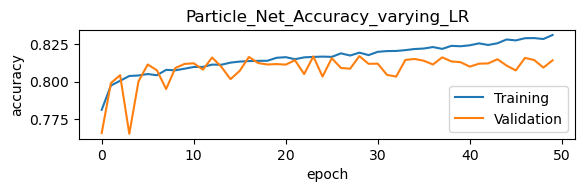

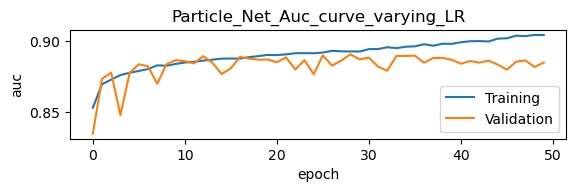

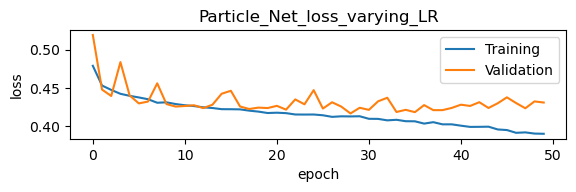

In [30]:
plt.subplot(3,1,1)
plt.plot(results_lr_schedule.history['accuracy'],label='Training')
plt.plot(results_lr_schedule.history['val_accuracy'],label='Validation')
plt.title('Particle_Net_Accuracy_varying_LR')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.subplot(3,1,2)
plt.plot(results_lr_schedule.history['auc'],label='Training')
plt.plot(results_lr_schedule.history['val_auc'],label='Validation')
plt.title('Particle_Net_Auc_curve_varying_LR')
plt.xlabel('epoch')
plt.ylabel('auc')
plt.legend()
plt.show()

plt.subplot(3,1,3)
plt.plot(results_lr_schedule.history['loss'],label='Training')
plt.plot(results_lr_schedule.history['val_loss'],label='Validation')
plt.title('Particle_Net_loss_varying_LR')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## Evaluation

In [39]:
test_particlenet_fixed_LR=model.evaluate(test_data,y_test,
                                         batch_size=batch_size)
test_particlenet_lite_fixed_LR=model_lite.evaluate(test_data,y_test,
                                                   batch_size=batch_size)
test_particlenet_varying_LR=model_lr_schedule.evaluate(test_data,y_test,
                                                       batch_size=batch_size)
test_particlenet_lite_varying_LR=model_lr_schedule_lite.evaluate(test_data,y_test,
                                                                 batch_size=batch_size)

391/391 [==============================] - 9s 24ms/step - loss: 0.4147 - accuracy: 0.8177 - auc: 0.8923


## Conclusion

#### In TensorFlow/Keras, two Classical Graph Neural Network (GNN) models have been implemented with variations in their learning rates. One set of models utilizes a fixed learning rate of 3e-4, which is a popular value for the Adam optimizer as recommended by Andrej Karpathy. The other set of models employs a varying learning rate. 

#### Although all the models gave close results, but ParticleNet_lite with varying LR gave the best results with accuracy of 81.77% and an auc score of 0.8923 which is comparable to their results in the paper [Jet Tagging via Particle Clouds]

[Jet Tagging via Particle Clouds]:https://arxiv.org/pdf/1902.08570.pdf

#### An important thing to note is that the model takes significant time for training 100000 samples.

#### Below is a reference-

**1) PARTICLE_NET**
 
|    GPU        | Time for first epoch| Subsequent epochs time(per epoch)|
|---------------|:-------------------:|----------------------:|
| Colab TeslaT4 |    225-230sec       |        200-205sec     |
| Kaggle T4 x2  |    150-160sec       |        120-124sec     |


**2) PARTICLE_NET_LITE**
 
|    GPU        | Time for first epoch| Subsequent epochs time(per epoch) |
|---------------|:-------------------:|----------------------:|
| Colab TeslaT4 |    120-130sec       |        90-100sec      |
| Kaggle T4 x2  |    60- 70sec        |        39-44sec       |

#### Comparing the tables above, it is evident that the use of parallel and distributed computing with Kaggle T4x2 has significantly reduced the training time by approximately 30-50%.
